In [2531]:
# pip install --upgrade google-api-python-client

In [2532]:
# pip install --upgrade google-auth-oauthlib google-auth-httplib2

In [2533]:
import urllib
import json
import requests
import pandas as pd
import numpy as np
import pickle
import re


In [2534]:
import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [2535]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 50)

# Collect Data

## Get data from YouTube

### Get lists of videos from some SC2 channels

Main analysis will be on videos & stats from channel **HarstemCasts**<br>
https://www.youtube.com/c/HarstemCasts/videos

In [2536]:
api_key = "*SECRET*"

# Channel IDs
harstem_casts_id = 'UCmwOm-YjCmcddE9xe9sEpUg'
harstem_id = 'UCCRdB9rqzP2m7bPYb5drH_Q'
lowko_clips_id = 'UCpPS0EHyYGxHlzH0RmARg6Q'
sc2hl_id = 'UC9C07cryUrKzLuAzwITPA3A'

In [2537]:
def get_channel_id_by_username(api_key, username):
    result = requests.get("https://www.googleapis.com/youtube/v3/channels?part=snippet&forUsername=" + username + "&key=" + api_key)
    result = result.json()
    result = pd.json_normalize(result)
    channel_id = result['items'][0][0]['id']
    print('Username: ' + username + '\nChannel ID: ' + channel_id)
    return(channel_id)

In [2538]:
# lowko_tv_id = get_channel_id_by_username(api_key, 'Felixje0')

In [2539]:
def get_videos_from_channel(api_key, channel_id):
    result = requests.get("https://www.googleapis.com/youtube/v3/search?order=date&part=snippet&channelId=" + channel_id + "&maxResults=50&key=" + api_key)
    print('Request Status: ')
    print(result)
    print('\n')
    video_list =  result.json()
    video_list = pd.json_normalize(video_list)    
    list_of_all_videos = video_list['items'][0]    
    channel_name = list_of_all_videos[0]['snippet']['channelTitle']    
    print('Channel: ' + channel_title)
    channel_name = channel_name.lower().replace(' ', '_').replace('.', '_')
    i = 2
    while 'nextPageToken' in video_list:        
        print('Token Page' + str(i) + ': ' + video_list['nextPageToken'][0])
        i = i+1
        result_json = requests.get("https://www.googleapis.com/youtube/v3/search?order=date&part=snippet&channelId=" + channel_id + "&maxResults=50&key=" + api_key + "&pageToken=" + video_list['nextPageToken'][0])
        result = result_json.json()
        video_list = pd.json_normalize(result)
        list_of_all_videos.extend(video_list['items'][0])    
    print('\n' + str(len(list_of_all_videos)) + ' videos loaded')    
    # save as pickle file
    with open(channel_name + '_videolist_raw.pkl', 'wb') as f:
        pickle.dump(list_of_all_videos, f)
    print('saved as ' + channel_name + '_videolist_raw.pkl')
    return(list_of_all_videos)

In [2540]:
## Get videolists from popular SC2 channels and save them as pickle file
# lowko_clips_videolist = get_videos_from_channel(api_key, lowko_clips_id)
# harstem_videolist = get_videos_from_channel(api_key, harstem_id)
# harstem_casts_videolist = get_videos_from_channel(api_key, harstem_casts_id)
# lowko_tv_videolist = get_videos_from_channel(api_key, lowko_tv_id)
# sc2hl_videolist = get_videos_from_channel(api_key, sc2hl_id)

In [2541]:
# open pickle fle
with open('harstem_casts_videolist_raw.pkl', 'rb') as f:
    list_of_all_videos = pickle.load(f)    

In [2542]:
def open_videolist(channel_name):
    with open(channel_name + '_videolist_raw.pkl', 'rb') as f:
        return(pickle.load(f))

In [2543]:
# harstem = open_videolist('harstem_casts')

In [2544]:
def clean_videolist(channel_name):
    videolist = open_videolist(channel_name)
    videos = pd.DataFrame(pd.json_normalize(videolist))
    videos.columns = videos.columns.str.lower().str.replace(' ', '_').str.replace('.', '_', regex=True)
    videos = videos[videos.id_kind == "youtube#video"] # delete playlists
    videos.reset_index(drop=True, inplace=True) # Reset index because we deleted the playlists
    print(channel_name)
    print('Structure before cleaning:\n')
    print('Columns: ' + str(videos.columns))
    print('Shape: ' + str(videos.shape))
    print('Data types: ' + str(videos.dtypes))    
    print('Type of videos:' + str(videos['id_kind'].value_counts()))
    print('Columns snippet_publishedat & snippet_publishtime are equal: '+ str(videos['snippet_publishedat'].equals(videos['snippet_publishtime']))) # Seem to be columns with identical content
    print('\n')
    videos.drop(['kind', 'id_kind', 'etag', 'snippet_publishtime', 'snippet_channelid', 'snippet_thumbnails_default_url', 'snippet_thumbnails_default_width', 'snippet_thumbnails_default_height', 'snippet_thumbnails_medium_url', 'snippet_thumbnails_medium_width', 'snippet_thumbnails_medium_height', 'snippet_thumbnails_high_url', 'snippet_thumbnails_high_width', 'snippet_thumbnails_high_height', 'snippet_channeltitle', 'snippet_livebroadcastcontent', 'snippet_publishtime', 'id_channelid'], axis=1, inplace=True)
    if 'id_playlistid' in videos.columns:
        videos.drop(['id_playlistid'], axis=1, inplace=True)
    videos.rename(columns={'id_videoid' : 'id', 'snippet_publishedat' : 'date', 'snippet_title' : 'title', 'snippet_description' : 'description'}, inplace=True)    
    videos['date'] = pd.to_datetime(videos['date'], errors='coerce')
    print('Structure after cleaning:\n')
    print('Columns: ' + str(videos.columns))
    print('Shape: ' + str(videos.shape))
    print('Data types: ' + str(videos.dtypes))    
    # save as pickle file
    with open(channel_name + '_videolist_cleaned.pkl', 'wb') as f:
        pickle.dump(videos, f)
    print('saved as ' + channel_name + '_videolist_cleaned.pkl')
    print('--------------------------------------------------')
    return(videos)

In [2545]:
with HiddenPrints():
    lowko_clips_videolist = clean_videolist('lowko_clips')
    harstem_casts_videolist = clean_videolist('harstem_casts')

In [2546]:
videos = harstem_casts_videolist

In [2547]:
videos.shape

(479, 4)

### Get Channelstats

In [2548]:
# I don't use those data yet

In [2549]:
from googleapiclient.discovery import build

In [2550]:
youTubeApiKey = api_key
youtube = build("youtube","v3",developerKey = youTubeApiKey)

In [2551]:
channelUsername= 'HarstemCasts'
# channelStats = youtube.channels().list(part = "snippet,contentDetails,statistics", id=harstem_casts).execute()

In [2552]:
# channelStats

### Get Videostats

In [2553]:
def get_videostats(api_key, channel_name):    
    # Load id from pickle fle
    with open(channel_name + '_videolist_cleaned.pkl', 'rb') as f:
        videolist = pickle.load(f)
    videoStatistics = []
    print('Grab stats for ' + str(len(videolist['id'])) + ' videos')
    i = 1
    for video_id in videolist['id']:
        if i % 50 == 0:
            print('stats for 50 videos loaded')
        i= i+1
        videoData = youtube.videos().list(id=video_id,part = "statistics").execute()
        videoStatistics.append(videoData["items"][0]["statistics"])   
    print('All stats loaded')
    videoStatistics = pd.json_normalize(videoStatistics)    # save as pickle file
    # save as pickle file
    with open(channel_name + '_video_stats.pkl', 'wb') as f:
        pickle.dump(videoStatistics, f)
    print('saved as ' + channel_name + '_video_stats.pkl')    
    return(videoStatistics)

In [2554]:
# lowko_clips_video_stats = get_videostats(api_key, 'lowko_clips')
# harstem_casts_video_stats = get_videostats(api_key, 'harstem_casts')

### Get Video duration

In [2555]:
def get_videoduration(api_key, channel_name):    
    # Load id from pickle fle
    with open(channel_name + '_videolist_cleaned.pkl', 'rb') as f:
        videolist = pickle.load(f)
    i = 1
    durations_as_string = []
    print('Grab stats for ' + str(len(videolist['id'])) + ' videos')
    for video_id in videolist['id']:
        if i % 50 == 0:
            print('durations for 50 videos loaded')
        i = i+1
        result = requests.get("https://www.googleapis.com/youtube/v3/videos?id=" + video_id + "&part=contentDetails&key=" + api_key)
        result = result.json()
        result = pd.json_normalize(result)
        duration = result['items'][0][0]['contentDetails']['duration']
        durations_as_string.append(duration)
        
    # PLEEEEAAAAAAAAASE SHOW ME THE PYTHON WAY!!!!
    durations = []
    for duration in durations_as_string:
        duration = duration.replace('PT', '')
        position_S = duration.find('S')
        position_M = duration.find('M')
        position_H = duration.find('H')
        if position_H != -1:
            hours = duration[0:position_H]
        else:
            hours = 0
        if position_M != -1:
            minutes = duration[position_H+1:position_M]
        else:
            minutes = 0
            position_M = position_H
        if position_S != -1:
            seconds = duration[position_M+1:position_S]
        else: 
            seconds = 0
        durations.append(int(hours) * 3600 + int(minutes) * 60 + int(seconds))    
    # save as pickle file
    with open(channel_name + '_video_durations.pkl', 'wb') as f:
        pickle.dump(durations, f)
    print('saved as ' + channel_name + '_video_durations.pkl')    
    return(durations)

In [2556]:
# durations = get_videoduration(api_key, 'harstem_casts')
# durations = get_videoduration(api_key, 'lowko_clips')

In [2557]:
# print(videos.shape)
# print(len(durations))

### Merge Videolist & Stats

In [2558]:
videos

,id,date,title,description
0,hYEfllJWoHY,2022-05-20 21:03:09+00:00,INCREDIBLE Zerg vs Terran StarCraft II MATCH | Rogue (Z) vs Cure (T),"Thanks for watching this video. Please smash like as it helps me a lot, adios. Twitter: www.twitter.com/harstemsc2 Twitch: ..."
1,hEk0zdpSRjc,2022-05-19 20:51:10+00:00,What Is This FACTORY Up TO? | SpeCial (T) vs Trap (P),"Thanks for watching this video. Please smash like as it helps me a lot, adios. Twitter: www.twitter.com/harstemsc2 Twitch: ..."
2,61Nu9z6s6t8,2022-05-18 20:24:50+00:00,The 2019 KATOWICE Champion IS BACK | soO (Z) vs herO (P) best of 5,"Thanks for watching this video. Please smash like as it helps me a lot, adios. Twitter: www.twitter.com/harstemsc2 Twitch: ..."
3,KMmWlYHBwXw,2022-05-17 21:24:54+00:00,The #1 Protoss Plays MASS ORACLE And it works | Reynor (Z) vs herO (P),"Thanks for watching this video. Please smash like as it helps me a lot, adios. Twitter: www.twitter.com/harstemsc2 Twitch: ..."
4,Ifw42gjWl7w,2022-05-16 19:58:09+00:00,Reynor And Maru Play a WILD Lategame,"Thanks for watching this video. Please smash like as it helps me a lot, adios. Twitter: www.twitter.com/harstemsc2 Twitch: ..."
...,...,...,...,...
474,xyC8RQgPlkY,2020-04-03 20:47:18+00:00,Serral MASS BANELING drops | Serral (Z) vs Harstem (P),"A game I played on Ladder vs Mr serral. I know I talk about myself in the third person. Weird to talk in first person when casting, but ..."
475,wmo8ak8jmKo,2020-03-29 20:16:26+00:00,NYDUS WORMS never stop?? - Zest (P) vs SoO (Z),In todays video we have Zest vs SoO. An absolutely wild Protoss vs Zerg in which a lot of the rules of traditional starcraft get ...
476,3ZPY6FbPgdo,2020-03-26 22:45:00+00:00,Carrier/phoenix vs TERRAN? Heromarine (T) vs Harstem (P),Today we have a look at a ladder game I recently played on one of my smurf accounts vs Heromarine. Real fun game with skytoss ...
477,GVdBY_q7a60,2020-03-26 00:09:12+00:00,AGRESSIVE Protoss. Trap(p) vs Stats(p),Today we have Trap vs Stats from this week's olimoleague. Fantastic game between two of the best protoss players in the world.


In [2559]:
# open pickle fle
with open('harstem_casts_videolist_cleaned.pkl', 'rb') as f:
    videos = pickle.load(f)
    
with open('harstem_casts_video_stats.pkl', 'rb') as f:
    video_stats = pickle.load(f)

with open('harstem_casts_video_durations.pkl', 'rb') as f:
    video_durations = pickle.load(f)


In [2560]:
videos.sample(3)

,id,date,title,description
288,5SG4BVKg6QU,2021-06-27 17:00:02+00:00,"Neeblet (P) vs ShoWTimE (P) (Casters: MaxPax, Harstem, PtitDrogo) | The Biggest Loser Round of 8","The Biggest Loser is a $1001 USD tournament featuring 8 top notch StarCraft 2 pros playing in a single elimination, best of 5 ..."
124,3Cerzb2q44w,2022-01-09 22:12:46+00:00,Classic Gives Byun a taste of CHEESE | ByuN (T) vs Classic (P),"Classic vs byun a cheese filled series. Delicious. Thanks for watching this video. Please smash like as it helps me a lot, adios."
53,Eafctvm3E2I,2022-03-25 22:54:19+00:00,Protoss INSANE Builds And Rogue&#39;s ROACH All-in | Rogue (Z) vs herO (P),"Thanks for watching this video. Please smash like as it helps me a lot, adios. Twitter: www.twitter.com/harstemsc2 Twitch: ..."


In [2561]:
video_stats.sample(3)

,viewCount,likeCount,favoriteCount,commentCount
92,16965,447,0,27
315,17771,477,0,42
439,3873,140,0,15


In [2562]:
print(videos.shape)
print(video_stats.shape)
print(len(video_durations))

(479, 4)
(479, 4)
479


In [2563]:
videos = pd.concat([videos, video_stats], axis=1)

In [2564]:
videos['duration'] = video_durations

In [2565]:
videos['viewCount'] = pd.to_numeric(videos['viewCount'], errors='coerce')
videos['likeCount'] = pd.to_numeric(videos['likeCount'], errors='coerce')
videos['commentCount'] = pd.to_numeric(videos['commentCount'], errors='coerce')

In [2566]:
videos.dtypes

id                            object
date             datetime64[ns, UTC]
title                         object
description                   object
viewCount                      int64
likeCount                      int64
favoriteCount                 object
commentCount                   int64
duration                       int64
dtype: object

In [2567]:
videos['like_perc'] = videos['likeCount'] / videos['viewCount']
videos['comment_perc'] = videos['commentCount'] / videos['viewCount']

In [2568]:
videos.sample(3)

,id,date,title,description,viewCount,likeCount,favoriteCount,commentCount,duration,like_perc,comment_perc
188,7He6ENf-SSE,2021-11-02 22:52:55+00:00,Is Dream In Serral&#39;s Brain? | Serral (Z) vs Dream (T),"Wanted to watch just one game, but then i decided to do the whole series because why not. Good stuff. Thanks for watching this ...",26138,621,0,35,2632,0.023759,0.001339
92,gRjjt-4eHcc,2022-02-12 23:02:57+00:00,herO&#39;s Cheeses Keep ByuN On his Toes | ByuN (T) vs herO (P),"Thanks for watching this video. Please smash like as it helps me a lot, adios. Twitter: www.twitter.com/harstemsc2 Twitch: ...",16965,447,0,27,1570,0.026348,0.001592
376,PGLY_mjxE4U,2020-12-03 20:00:10+00:00,Serral And ShoWTimE Play an EXTREMELY High Level Best Of 5,"Serral vs ShoWTimE Best of 5 Insane games, insane plays. Beautiful. Thanks for watching this video. Please smash like as it ...",38105,759,0,71,3780,0.019919,0.001863


In [2569]:
print(videos.shape)
print(videos.isnull().sum())

(479, 11)
id               0
date             0
title            0
description      0
viewCount        0
likeCount        0
favoriteCount    0
commentCount     0
duration         0
like_perc        0
comment_perc     0
dtype: int64


In [2570]:
if "favoriteCount" in videos.columns:
    print(videos['favoriteCount'].unique())
    videos.drop(['favoriteCount'], axis=1, inplace=True)

['0']


In [2571]:
if "description" in videos.columns:
    videos.drop(['description'], axis=1, inplace=True)

## Get a list with pro player names

### Grab player_list from TeamLiquid

In [2572]:
from bs4 import BeautifulSoup

In [2573]:
url = "https://liquipedia.net/starcraft2/Players_(All)"

In [2574]:
with open('teamliquid_response.pkl', 'rb') as f:
    response = pickle.load(f)

In [2575]:
soup = BeautifulSoup(response.content, "html.parser")

In [2576]:
player_ids_list = []
for player_id in soup.select('table.wikitable > tbody > tr > td:nth-child(1) > a'):
    player_ids_list.append(player_id.get_text())
len(player_ids_list)

0

In [2577]:
player_names_list = []
for player_name in soup.select('table.wikitable > tbody > tr > td:nth-child(2)'):
    player_names_list.append(player_name.get_text())
len(player_names_list)

0

In [2578]:
player_teams_list = []
for team in soup.select('table.wikitable > tbody > tr > td:nth-child(3)'):
    player_teams_list.append(team.get_text())
len(player_teams_list)

0

In [2579]:
player_race_list = []
for race in soup.select('table.wikitable > tbody > tr > td:nth-child(4)'):
    player_race_list.append(race.get_text())
len(player_race_list)

0

In [2580]:
# Won't use those for now
# maybe interesting to automatically grab more data about each player lateron
player_link_list = []
for link in soup.select('table.wikitable > tbody > tr > td:nth-child(5)'):
    player_link_list.append(link)
len(player_link_list)

0

In [2581]:
zipped = list(zip(player_ids_list, player_names_list, player_teams_list, player_race_list))
players = pd.DataFrame(zipped, columns=['id', 'name', 'team', 'race'])

In [2582]:
players

,id,name,team,race


In [2583]:
print(players['team'].value_counts())
players["team"].mask(players["team"]  == 'ZZZZZ', 'no_team', inplace=True)

Series([], Name: team, dtype: int64)


In [2584]:
for col in players:
    players[col]= players[col].str.strip()

### Grab top 100 player_list from esportsearnings

In [2585]:
with open('esportsearning_response.pkl', 'rb') as f:
    response = pickle.load(f)

In [2586]:
soup = BeautifulSoup(response.content, "html.parser")

In [2587]:
# Get player nicknames
player_id = []
for p_id in soup.select('table.detail_list_table > tbody > tr > td:nth-child(2) > a:nth-child(2)'):
    player_id.append(p_id.get_text())
    
# Get player nicknames
realname = []
for rn in soup.select('table.detail_list_table > tbody > tr > td:nth-child(3)'):
    realname.append(rn.get_text())
    
# Get lifetime winning
winnings = []
for w in soup.select('table.detail_list_table > tbody > tr > td:nth-child(4)'):
    winnings.append(w.get_text())

In [2588]:
print(len(player_id))
print(len(realname))
print(len(winnings))

100
100
100


In [2589]:
players_top100 = pd.DataFrame()
players_top100['id'] = player_id
players_top100['realname'] = realname
players_top100['winnings'] = winnings

### Load player_list from pickle file

**BE AWARE!** <br>
Dataframe players is loaded fom a pickle file<br>
it's not collected in real time

In [2590]:
# open pickle fle
with open('players_list.pkl', 'rb') as f:
    players = pickle.load(f)

with open('players_top100_list.pkl', 'rb') as f:
    players_top100 = pickle.load(f)
    

In [2591]:
players.sample(3)

,id,name,team,race
1311,Sea,Yum Bo-sung,no_team,Terran
518,MisterL,,no_team,"Protoss,Terran"
1293,Revenge,Kim Kun,no_team,Terran


In [2592]:
players_top100.sample(3)

,id,realname,winnings
66,PtitDrogo,Théo Freydière,"$137,741.63"
18,Solar,"Kang, Min Soo","$446,299.50"
94,Squirtle,"Park, Hyun Woo","$92,282.22"


# Extract data from title

## Get player names from title

### Automatically

In [2593]:
videos['title'].sample(3)

221                                    Can MaxPax stop Clem&#39;s Multitask
64           Dream&#39;s FAKE Mech Opener vs Solar | Solar (Z) vs Dream (T)
297    An Unorthodox Protoss vs Zerg Lategame | Bly (Z) vs FightingFrog (P)
Name: title, dtype: object

In [2594]:
players[players['id'] == 'SpeCial']

,id,name,team,race
652,SpeCial,Juan Carlos Tena Lopez,PSISTORM Gaming,Terran


In [2595]:
print(videos['title'].isna().sum())
print(players['id'].isna().sum())

0
0


In [2596]:
#todo: fix participants
# - remove doubles
# - check for spelling
# - replaces missing with 'unknown player', 
# - maybe differentiate between 'unknown player' and 'not named player'
# - add barcode players   

### first check for exact names with exact spelling
## if less than two participants 
# ignore cases
# 
## if more than two

In [2597]:
# videos_copy = videos.copy()

# videos = videos.iloc[0:100]

In [2598]:
with open('temp_participant_count.pkl', 'rb') as f:
    participant_count = pickle.load(f)

In [2599]:
with open('temp_participant_list.pkl', 'rb') as f:
    participant_list = pickle.load(f)

In [2600]:
print(videos.shape)
print(len(participant_list))
print(len(participant_count))

(479, 9)
479
479


In [2601]:
%%capture --no-display
videos['participants'] = participant_list
videos['participant_count'] = participant_count

In [2602]:
videos.sample(10)

,id,date,title,viewCount,likeCount,commentCount,duration,like_perc,comment_perc,participants,participant_count
261,DJuP1KhBJM0,2021-08-03 20:15:00+00:00,Bly And MaxPax Go WILD | MaxPax (P) vs Bly (Z),19117,720,73,1495,0.037663,0.003819,"[Bly, MaxPax]",2
167,mO406-7yMdI,2021-11-24 21:56:19+00:00,The Marauder Cancel That Saved The Game | Time(T) vs Ragnarok(Z),12093,399,13,1055,0.032994,0.001075,"[TIME, RagnaroK]",2
148,dm_xXyWI4-Q,2021-12-15 23:10:50+00:00,Zoun&#39;s HIDDEN Dark Shrine | Zest (P) vs Zoun (P),10298,336,23,1071,0.032628,0.002233,"[Dark, Zest]",2
211,b5DnAjdIItE,2021-10-04 21:31:18+00:00,Can Clem Deal With BLINK DTS?! | MaxPax (P) vs Clem (T),16904,577,28,1412,0.034134,0.001656,"[Clem, MaxPax]",2
335,dh7jQPGdwiM,2021-03-08 18:00:09+00:00,The Most AGRESSIVE Best of 5 | Parting (P) vs TYTY (T),10398,394,48,1873,0.037892,0.004616,"[TY, PartinG]",2
200,VyRIxRFQqIA,2021-10-18 21:16:27+00:00,Rogue And Byun Speedrun best of 5 | ByuN(T) vs Rogue(Z),15550,600,34,911,0.038585,0.002186,"[Rogue, ByuN]",2
83,ZreldrLl-rc,2022-02-21 18:00:13+00:00,This New MAP Is Beautiful | Solar (Z) vs Spirit (T),11189,372,28,984,0.033247,0.002502,"[Solar, Spirit, New]",3
291,gG1PtY3evT8,2021-06-20 17:00:18+00:00,When A Cannonrusher Plays Macro | Strange (P) vs KingCobra (P),6074,264,19,779,0.043464,0.003128,"[KingCobra, Strange]",2
411,88X7MCYqwww,2020-08-05 17:00:04+00:00,StarCraft 2: Dark vs Taeja,14746,424,35,1169,0.028754,0.002374,"[Dark, TaeJa]",2
316,AGGa99lvh30,2021-04-20 17:10:26+00:00,Clem (T) vs Elazer (Z),7482,303,27,1329,0.040497,0.003609,"[Elazer, Clem]",2


In [2603]:
videos[videos['participant_count'] < 2]

,id,date,title,viewCount,likeCount,commentCount,duration,like_perc,comment_perc,participants,participant_count


In [2604]:
videos['participants'][videos['participant_count'] > 2]

2                      [soO, herO, Cham]
20              [Zest, GuMiho, Has, san]
23                    [Solar, herO, Has]
32                   [Classic, Cure, XY]
34                    [ByuN, herO, HerO]
                     ...                
451               [Clem, ShoWTimE, TIME]
457             [Elazer, ShoWTimE, TIME]
458     [Reynor, herO, HerO, HeRoMaRinE]
469     [Serral, herO, HerO, HeRoMaRinE]
476    [Harstem, herO, HerO, HeRoMaRinE]
Name: participants, Length: 73, dtype: object

In [2605]:
# Remove doubles and & remove short player names when longer playername exists, e.g. time and showtime, hero and heromarine
participant_list = []
participant_count = []
for participants in videos['participants'][videos['participant_count'] > 2]:
    # print('Old list ' + str(participants))
    participants_lowercases = [x.lower() for x in participants]
    participants = list(set(participants_lowercases))
    # print('New list ' + str(participants))  # removed doubles
    participants_per_game = []
    for player in participants:
        other_participants = participants.copy()  
        other_participants.remove(player)       
        # check if this playername is part of another playername like "time" and "showtime" or "hero" and "heromarine"
        # print('check if ' + player + ' is in ' + str(other_participants))        
        r = re.compile(player, re.IGNORECASE)
        longer_player_name = list(filter(r.match, other_participants))        
        # print(list(map(r.match, other_participants)))
        # hardcoded: remove player time when player showtime is also in the list 
        if 'time' in participants and 'showtime' in participants:
            participants.remove('time')
        # because I run into some odd problems        
        if longer_player_name:
            participants.remove(player)
            # print('Player to delete: ' + player)
            # print('Longer player name: ' + str(longer_player_name))
    participant_count.append(len(participants))
    participant_list.append(participants)
    # print(str(participants) + '\n')
    

In [2606]:
print(videos['participants'][videos['participant_count'] > 2].shape)
print(len(participant_list))
print(len(participant_count))


(73,)
73
73


In [2607]:
%%capture --no-display
videos['participants'][videos['participant_count'] > 2] = participant_list
videos['participant_count'][videos['participant_count'] > 2] = participant_count

In [2608]:
videos[videos['participant_count'] > 2].sample(3)

,id,date,title,viewCount,likeCount,commentCount,duration,like_perc,comment_perc,participants,participant_count
249,-OwqU1TzLMs,2021-08-16 19:29:57+00:00,herO shows his CREATIVITY | Leenock (Z) vs herO,24424,741,75,1847,0.030339,0.003071,"[hero, ty, leenock]",3
288,5SG4BVKg6QU,2021-06-27 17:00:02+00:00,"Neeblet (P) vs ShoWTimE (P) (Casters: MaxPax, Harstem, PtitDrogo) | The Biggest Loser Round of 8",7084,277,65,2919,0.039102,0.009176,"[ptitdrogo, showtime, harstem, neeb]",4
71,3h0x0YK38bg,2022-03-05 21:35:06+00:00,Crazy Hellion Cyclone Build STARTLES Dark | Special (T) vs Dark (Z),10625,409,20,1310,0.038494,0.001882,"[crazy, dark, art]",3


### Manual tweaking

In [2609]:
# Delete participants manuall where therea are more than two participants
print(videos[videos['participant_count'] > 2].shape)
videos[videos['participant_count'] > 2].sample(10)

(45, 11)


,id,date,title,viewCount,likeCount,commentCount,duration,like_perc,comment_perc,participants,participant_count
41,gwJjbiJle5M,2022-04-06 20:28:27+00:00,The Korean Has Goes WILD vs DRG | DRG(Z) vs Prince (P),11285,340,18,2455,0.030128,0.001595,"[drg, has, prince]",3
212,amypLKLG7jA,2021-10-03 19:48:03+00:00,Does Has Take the Bait? | Has (P) vs Expect (T),15757,365,30,2705,0.023164,0.001904,"[take, ak, has, expect]",4
42,3OX7LQLfJv0,2022-04-05 21:46:32+00:00,Game Of The Year. | Goblin (P) vs Krystianer (P),15224,601,37,1953,0.039477,0.002430,"[goblin, krystianer, ian]",3
340,6k0g50g62FY,2021-02-27 18:00:03+00:00,Insanely CLOSE Terran Vs Zerg Best of 3 | Reynor (Z) vs HeRoMaRinE (T),12950,281,24,2948,0.021699,0.001853,"[san, heromarine, reynor]",3
239,GS6YJ1zJTgY,2021-08-27 22:36:37+00:00,"Two Best of 3&#39;s, 15 minutes total. SpeCial vs herO &amp; Harstem vs Maxpax",25957,968,64,902,0.037292,0.002466,"[hero, special, harstem]",3
35,pUNkKtd0ooo,2022-04-13 19:00:14+00:00,MaxPax&#39;s WILD Phoenix MICRO | Classic (P) vs MaxPax (P),9300,327,31,1543,0.035161,0.003333,"[classic, maxpax, phoenix]",3
364,tg4yHe9y7VY,2021-02-05 16:00:32+00:00,Harstem And Lambo Play TERRAN Vs Reynor,13789,650,36,1304,0.047139,0.002611,"[harstem, reynor, lambo]",3
61,FLahKFbS14I,2022-03-17 20:00:07+00:00,Can CLEM&#39;s INSANE Micro Result in a COMEBACK? | Mana (P) vs Clem (T),11297,386,12,1063,0.034168,0.001062,"[san, clem, mana]",3
107,GYXHXZCuxxw,2022-01-27 22:33:42+00:00,The PROXY RAX Master uThermal | Lambo (Z) vs uThermal,14797,437,21,1661,0.029533,0.001419,"[xy, uthermal, lambo]",3
190,Dkz4ARx18YM,2021-10-31 22:00:03+00:00,herO&#39;s Blink Dark Templar Squad Keeps ShoWTimE Busy | herO (P) vs ShoWTimE (P),10880,339,15,1175,0.031158,0.001379,"[hero, showtime, dark]",3


In [2610]:
players[players['id'].str.contains('xy', case=False)] 

,id,name,team,race
634,ProXy,Azamat Serikbaev,Hasu Players,Terran
907,OxygeN,Wei Yang Lim,no_team,Terran


In [2611]:
players_top100[players_top100['id'].str.contains('time', case=False)] 

,id,realname,winnings
28,ShoWTimE,Tobias Sieber,"$314,100.93"
42,TIME,"Li, Peinan","$226,286.48"


In [2612]:
# players_to_drop = [228, 296, 304, 457, 1484, 1308, 647, 347, 1235, 1236, 1236, 350
# players.drop(labels=players_to_drop, inplace=True)


### Randomly delete when there are more than 2 participants

In [2613]:
videos[videos['participant_count'] > 2].sample(5)

,id,date,title,viewCount,likeCount,commentCount,duration,like_perc,comment_perc,participants,participant_count
165,irTvRKYvnSU,2021-11-26 22:47:29+00:00,"Elazer Wasting Everyone&#39;s Time, Including yours. | Elazer (Z) vs Strange (P)",10469,391,52,1444,0.037348,0.004967,"[elazer, eve, strange]",3
35,pUNkKtd0ooo,2022-04-13 19:00:14+00:00,MaxPax&#39;s WILD Phoenix MICRO | Classic (P) vs MaxPax (P),9300,327,31,1543,0.035161,0.003333,"[classic, maxpax, phoenix]",3
71,3h0x0YK38bg,2022-03-05 21:35:06+00:00,Crazy Hellion Cyclone Build STARTLES Dark | Special (T) vs Dark (Z),10625,409,20,1310,0.038494,0.001882,"[crazy, dark, art]",3
306,RsaflgL1TOM,2021-05-13 17:00:08+00:00,LONG TvT Macro Game | SouL (T) vs Marinelord (T),8091,336,32,1565,0.041528,0.003955,"[marinelord, rine, acro]",3
253,sZtpFGzBets,2021-08-12 19:30:15+00:00,INTENSE Terran Mech vs Zerg | SouL (T) vs Elazer (Z),14029,503,60,1081,0.035854,0.004277,"[intense, elazer, terran]",3


In [2614]:
print(videos[videos['participant_count'] > 2].shape)

(45, 11)


In [2615]:
# videos['participants'][videos['participant_count'] > 2]

In [2616]:
# delete player with the shortest name until there are only two players left
for participants in videos['participants']:
    while len(participants)>2:
        # print(participants)
        participants.remove(min(participants, key=len))
        # print(participants)
videos['participant_count'] = 2

In [2617]:
videos[videos['participant_count'] > 2]

,id,date,title,viewCount,likeCount,commentCount,duration,like_perc,comment_perc,participants,participant_count


## Get player race

### Get player racefrom title

In [2618]:
# (Z), (P), (T), Zerg, Protoss, Terran, tvst, ...
# get race from player
races_count = []
races = []
for title in videos['title']:    
    races_per_game = []
    title = title.lower()
    found_zergs = title.count('(z)')
    if found_zergs == 2:
        races_per_game.append('z')    
        races_per_game.append('z')            
    if found_zergs == 1:
        races_per_game.append('z')   
        
    found_protoss = title.count('(p)')
    if found_protoss == 2:
        races_per_game.append('p')    
        races_per_game.append('p')            
    if found_protoss == 1:
        races_per_game.append('p') 
        
    found_terrans = title.count('(t)')
    if found_terrans == 2:
        races_per_game.append('t')    
        races_per_game.append('t')            
    if found_terrans == 1:
        races_per_game.append('t') 
    races_per_game.sort()
    if not races_per_game:
        found_zergs = title.count(' z ') + title.count('zerg')
        if found_zergs == 2:
            races_per_game.append('z')    
            races_per_game.append('z')            
        if found_zergs == 1:
            races_per_game.append('z')   

        found_protoss = title.count(' p ') + title.count('protoss')
        if found_protoss == 2:
            races_per_game.append('p')    
            races_per_game.append('p')            
        if found_protoss == 1:
            races_per_game.append('p') 

        found_terrans = title.count(' t ') + title.count('terran')
        if found_terrans == 2:
            races_per_game.append('t')    
            races_per_game.append('t')            
        if found_terrans == 1:
            races_per_game.append('t')         
    # if not races_per_game: print(title) # list titles where no race was found    
    races_count.append(len(races_per_game))
    races.append(races_per_game)   
    

In [2619]:
# races

In [2620]:
videos['races'] = races
videos['races_count'] = races_count

In [2621]:
# videos['races'].iloc[0:30]

### Get missing races from player

In [2622]:
players.sample(3)

,id,name,team,race
1263,New,Bo In-jang,no_team,Protoss
9,Chappy,Christopher Chapman,no_team,Zerg
1790,CrunCher,Abdulaziz Abed,no_team,Protoss


In [2623]:
# when both races are unknown

races = []
for participant in videos['participants'][videos['races_count'] == 0]:
    races_per_match = []
    for player in participant:    
        # print(player)
        result =  players['race'][players['id'].str.match(player, case=False)]
        if not result.empty:
            race = players['race'][players['id'].str.match(player, case=False)].iloc[0]
        else:
            race = 'unknown'
        if race == 'Zerg': races_per_match.append('z')
        if race == 'Terran': races_per_match.append('t')
        if race == 'Protoss': races_per_match.append('p')
        if race == 'unknown': races_per_match.append('u')
    # print(participant)
    #print(len(races_per_match))
    # print(str(races_per_match) + '\n')
    if len(races_per_match) == 1:
        races_per_match.append('u')
    if len(races_per_match) == 0:
        races_per_match.append('u')
        races_per_match.append('u')                
    races.append(races_per_match)

In [2624]:
# races
len(races)

46

In [2625]:
videos[videos['races_count'] == 0]['races'].shape

(46,)

In [2626]:
# I don't know why - but that's the only way I made it work. May
# sth like 
# videos['races'][videos['races_count'] == 0] = races
# did not work. 
videos2 = videos[videos['races_count'] == 0].copy()

In [2627]:
videos2['races'] = races

In [2628]:
# videos2

In [2629]:
%%capture --no-display
# todo: there is an error. races is a list of lists with two entries each
# but only the first is added to the table
videos['races'][videos['races_count'] == 0] = videos2['races']
videos['races_count'][videos['races_count'] == 0] = 2

In [2630]:
players['race'][players['id'].str.match('Serral', case=False)].iloc[0]

'Zerg'

In [2631]:
#videos['races']

In [2632]:
# when one race is known fill the missing one with unknown
races = []
for race in videos['races'][videos['races_count'] == 1]:
    # print(race)
    race.append('u')

In [2633]:
%%capture --no-display
videos['races_count'][videos['races_count'] == 1]  = 2

In [2634]:
# videos.iloc[0:50]

# Use ML algorithms

In [2655]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

import seaborn as sns
import datetime
import statistics as stats
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor

import warnings
warnings.filterwarnings('ignore')

## Prepare data for machine learning

### Drop columns

In [2636]:
videos.drop(['id', 'title', 'likeCount', 'commentCount', 'like_perc', 'comment_perc', 'participant_count', 'races_count'], axis=1, inplace=True)

In [2637]:
videos.rename(columns={'viewCount' : 'view_count'}, inplace=True)

### Convert date to something meaningful

In [2638]:
# First video appeared
channel_starting_date = videos['date'].iloc[-1]

In [2639]:
videos['days_since_channel_started'] = (videos['date']  - channel_starting_date).dt.days

In [2640]:
videos['hour_of_the_day'] = videos['date'].dt.hour

In [2641]:
videos['day_of_the_week'] = videos['date'].dt.dayofweek

In [2642]:
videos.drop(['date'], axis=1, inplace=True)

### xy split & scaling

In [2643]:
num = videos._get_numeric_data()
num.drop(['view_count'], axis=1, inplace=True)
cat = videos.select_dtypes(np.object)

In [2644]:
cat.iloc[0:5]

,participants,races
0,"[Rogue, Cure]","[t, z]"
1,"[SpeCial, Trap]","[p, t]"
2,"[hero, cham]","[p, z]"
3,"[Reynor, herO]","[p, z]"
4,"[Maru, Reynor]","[t, z]"


In [2645]:
mlb = MultiLabelBinarizer()
participants = pd.DataFrame(mlb.fit_transform(cat['participants']),columns=mlb.classes_, index=cat.index)
races = pd.DataFrame(mlb.fit_transform(cat['races']),columns=mlb.classes_, index=cat.index)

In [2646]:
print(participants.shape)
print(races.shape)


(479, 180)
(479, 4)


In [2647]:
cat = pd.concat([participants, races], axis=1)
cat = races

In [2648]:
races

,p,t,u,z
0,0,1,0,1
1,1,1,0,0
2,1,0,0,1
3,1,0,0,1
4,0,1,0,1
...,...,...,...,...
474,1,0,0,1
475,1,0,0,1
476,1,1,0,0
477,1,0,0,0


In [2649]:
X = pd.concat([num, cat], axis = 1)
y = videos['view_count']

In [2650]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [2651]:
transformer = MinMaxScaler().fit(X_train) # need to keep transformer
X_train_normalized = transformer.transform(X_train)
X_train_norm = pd.DataFrame(X_train_normalized)
X_train_norm.columns = X_train.columns

transformer = MinMaxScaler().fit(X_test) # need to keep transformer
X_test_normalized = transformer.transform(X_test)
X_test_norm = pd.DataFrame(X_test_normalized)
X_test_norm.columns = X_test.columns

### correlation matrix

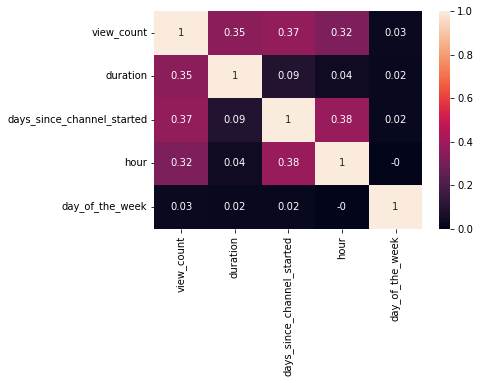

Wall time: 180 ms


In [2652]:
%%time
correlations_matrix = round(videos._get_numeric_data().corr(),2)
sns.heatmap(correlations_matrix, annot=True)
plt.show()

In [2654]:
lm = linear_model.LinearRegression()
lm.fit(X_train,y_train)

predictions = lm.predict(X_test)
r2_score(y_test, predictions)

0.3270882344131838

In [2656]:
regr = DecisionTreeRegressor(max_depth=5)
model = regr.fit(X_train, y_train)

In [2657]:
print("test data accuracy was: ",regr.score(X_test, y_test))
print("train data accuracy was: ",regr.score(X_train, y_train))

test data accuracy was:  0.37413318840810694
train data accuracy was:  0.5273749270073647
